In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
train_data = pd.read_json('../external_datasets/merged_api_data.json')
train_data = train_data[train_data['revenue'] > 0]
train_data = train_data.drop(columns=["company_name", "sales_revenue", "profit", "ebitda", "netIncome"])
train_data

,scope_1,scope_2,scope_3,revenue,grossProfitRatio
0,88553,783616,156845,128695000000,1.000000
3,69497,1613315,0,821279000000,1.000000
4,222353,1931555,0,724868000000,1.000000
5,66775,634510,3023784,94950000000,1.000000
8,139413,6381250,16340000,198270000000,0.684017
...,...,...,...,...,...
203,4612,133569,2701477,26914000000,0.649290
204,2420000,1460000,11636000,34229000000,0.438137
205,510000,400000,110300000,29492000000,0.813712
206,277000,291000,5166000,3569006000000,0.689873


In [11]:
def basic_growth_model(value_year1, value_year2, num_years):
    if value_year1 == 0:
        raise ValueError("value_year1 cannot be zero")
    
    value_growth_rate = (value_year2 - value_year1) / value_year1  # Calculate annual growth rate
    forecasted_values = [value_year2]

    for year in range(1, num_years + 1):
        # Ensure the adjusted growth rate does not become negative or excessively large
        adjusted_value_growth_rate = max(min(value_growth_rate * (1 - 0.1 * year), 1), -1)  # Cap the growth rate
        next_value = forecasted_values[-1] * (1 + adjusted_value_growth_rate)  # Forecast next year's value
        forecasted_values.append(next_value)

    return forecasted_values[1:]

def calculate_cagr(start_value, end_value, num_years):
    if start_value <= 0:
        raise ValueError("start_value must be greater than zero")
    
    cagr = (end_value / start_value) ** (1 / num_years) - 1
    return cagr

def forecaster(start_value, end_value, num_years):
    cagr = calculate_cagr(start_value, end_value, num_years - 1)
    forecasted_values = [end_value]
    
    for year in range(1, num_years):
        next_value = forecasted_values[-1] * (1 + cagr)
        forecasted_values.append(next_value)
    
    return forecasted_values


def calculate_forecast(data, key):
    if data['growth_rates'] is None:
        data['growth_rates'] = forecaster(data[f'{key}_last_year'], data[f'{key}_year_before_last'], 5)
    
    temperature = data['temperature']
    
    # Adjust growth rates by the temperature
    adjusted_growth_rates = [rate * temperature for rate in data['growth_rates']]
    
    forecast = [data[f'{key}_last_year']]
    for rate in adjusted_growth_rates:
        forecast.append(forecast[-1] * (1 + rate))
    
    return forecast[1:]


def calculate_revenue_forecast(data):
    return calculate_forecast(data, 'revenue')


def calculate_gross_profit_ratio_forecast(data):
    return calculate_forecast(data, 'grossProfitRatio')


def train_model(training_data, scope):
    X = training_data[['revenue', 'grossProfitRatio']]
    y = training_data[scope]
    model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
    return model


def predict_emissions(models, revenue_forecast, gross_profit_ratio_forecast, input_data):
    emissions_forecast = {
        'scope_1': [input_data['scope_1']],
        'scope_2': [input_data['scope_2']],
        'scope_3': [input_data['scope_3']]
    }
    
    for i in range(len(revenue_forecast)):
        revenue_df = pd.DataFrame({'revenue': [revenue_forecast[i]], 
                                   'grossProfitRatio': [gross_profit_ratio_forecast[i]]})
        emissions_forecast['scope_1'].append(models['scope_1'].predict(revenue_df)[0])
        emissions_forecast['scope_2'].append(models['scope_2'].predict(revenue_df)[0])
        emissions_forecast['scope_3'].append(models['scope_3'].predict(revenue_df)[0])
    
    return emissions_forecast



In [13]:
def plot_scope_forecast(emissions_forecast, model_name='Random Forest'):
    df = pd.DataFrame(emissions_forecast)
    x = np.arange(2023, 2029)  # Last year + next 5 years

    plt.style.use(['unhcrpyplotstyle', 'area'])
    fig, ax = plt.subplots()
    plot_stackplot(ax, df, x)
    draw_vert_line(ax)
    plot_legend(ax, df)
    plot_titles(ax, "GHG")
    add_caption(ax, x, model_name)
    add_annotations(ax)
    fig.tight_layout()
    plt.show()

def plot_stackplot(ax, df, x, order='default'):
    if order == 'ascending':
        total_area = df.sum(axis=0)
        sorted_columns = total_area.sort_values().index
        labels = format_legend_labels(sorted_columns)
        ax.stackplot(x, *[df[col] for col in sorted_columns], labels=labels, alpha=0.8)
    else:
        labels = format_legend_labels(df.columns)
        ax.stackplot(x, *[df[col] for col in df.columns], labels=labels, alpha=0.8)

def draw_vert_line(ax):
    ax.axvline(x=2024, color='black', linestyle='--')

def format_legend_labels(columns):
    return [col.replace('_', ' ').capitalize() for col in columns]

def plot_legend(ax, df):
    if len(df.columns) <= 4:
        num_cols = len(df.columns)
    else:
        num_cols = np.ceil(len(df.columns) / 2).astype(int)
    ax.legend(loc=(0, 1.05), ncol=num_cols)

def plot_titles(ax, scope):
    ax.set_title(f'Forecast of {scope} Emissions for the Next 5 Years', pad=50)
    ax.set_ylabel('Emissions (MT CO2e)')

def add_annotations(ax):
    prediction_start_year = 2024
    y_pos = ax.get_ylim()[1] * 0.1
    text_properties = {'xycoords': 'data', 'textcoords': 'offset points', 'va': 'center', 'color': 'black'}

    ax.annotate('Historical', xy=(prediction_start_year + 0.5, y_pos), xytext=(-55, -15),
                ha='right', fontsize=10, **text_properties)
    ax.annotate('Projected', xy=(prediction_start_year - 0.5, y_pos), xytext=(55, -15),
                ha='left', fontsize=10, **text_properties)

    ax.annotate('', xy=(prediction_start_year - 0.55, y_pos), xytext=(35, 0),
                arrowprops=dict(arrowstyle="->", color='black'), ha='center', **text_properties)
    ax.annotate('', xy=(prediction_start_year + 0.55, y_pos), xytext=(-35, 0),
                arrowprops=dict(arrowstyle="->", color='black'), ha='center', **text_properties)

def add_caption(ax, x, model_name):
    ax.set_xticks(x)
    plt.annotate(f"Forecast based on {model_name} Model", (0, 0), (0, -40),
                 xycoords='axes fraction', textcoords='offset points',
                 va='top', fontsize=9, color='#666666')

In [9]:
example_user_input = {
    'revenue_last_year': 128695000000,
    'revenue_year_before_last': 110695000000,
    'scope_1': 88553,
    'scope_2': 783616,
    'scope_3': 156845,
    "grossProfitRatio_last_year": 1.0, 
    "grossProfitRatio_year_before_last": 0.8,
    "ebitda_last_year": 72263000000, 
    "ebitda_year_before_last": 60000000000,
    "netIncome_last_year": 37676000000,
    "netIncome_year_before_last": 30000000000,
    'growth_rates': [0.05, 0.04, 0.08, 0.04, 0.05],  # Set to None to estimate values
    'temperature': 1.0
}

GHG emissions forecast for the next 5 years: {'scope_1': [88553, 88682.85, 25569.36, 18189.25, 18594.47, 21922.5], 'scope_2': [783616, 1765012.27, 199588.94, 265131.68, 266201.3, 307998.35], 'scope_3': [156845, 5720030.74, 513345.87, 3648993.2, 960986.6, 960986.6]}


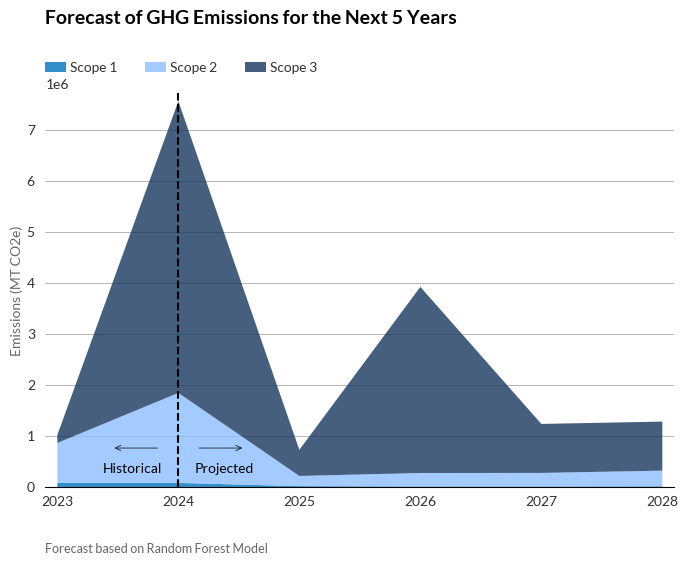

In [14]:
input_data = example_user_input

revenue_forecast = calculate_revenue_forecast(input_data)
gross_profit_ratio_forecast = calculate_gross_profit_ratio_forecast(input_data)

models = {
    'scope_1': train_model(train_data, 'scope_1'),
    'scope_2': train_model(train_data, 'scope_2'),
    'scope_3': train_model(train_data, 'scope_3')
}

emissions_forecast = predict_emissions(models, revenue_forecast, gross_profit_ratio_forecast, input_data)
print("GHG emissions forecast for the next 5 years:", emissions_forecast)

plot_scope_forecast(emissions_forecast)
